# Along-isobath averaging

This recipe shows how to perform an along-isobath averaging for scalar quantities (and vector quantities that are not rotated to along- and across-contour) in ACCESS-OM2-01.

Such along-isobath averaging is relevant for Antarctic shelf analyses, where a zonal average over a section of cross-shelf regions is needed.


### Some caveats: 

1) If there are deep valleys or troughs around the coastline, those will be averaged with deeper isobaths further offshore. Similarly, if there are seamounts off-shore, these will be averaged with shallower regions on the continental slope. Careful adjustment of the mask is necessary to ensure your results are interpretable. 

2) The bottom depths in ht and hu reflect the adaptive vertical grid in ACCESS, but the variables have NaNs at some of these depths. So, we end up with uneven binning if we bin along isobaths which do not exist in the variable field. As a simple fix, we mask our region of interest by `ht` and `hu`, but we bin by the bottom depth derived from the 3D variables (e.g., temperature) -- these are the `hu_coarse` and `ht_coarse` variables. This workaround can be further inspected in the future. 

#### Resources

This recipe was generated on a Large ARE instance, and may not work on smaller sizes.
___

This notebook was run with `PYTHONWARNINGS="ignore"` set in the environment variables. We do not recommend doing so as it may hide useful information. However, for the purposes of this recipe, it was necessary to hide these warnings. If you run this recipe without `PYTHONWARNINGS="ignore"` set, you may see a number of additional warnings. 

Load the necessary modules.

In [1]:
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram
from dask.distributed import Client

import warnings, os
# Set warnings to only show once - we are going to get a lot of repetitive warnings later on
warnings.filterwarnings(action='once',category=RuntimeWarning)
warnings.filterwarnings(action='once',category=FutureWarning)
os.environ["PYTHONWARNINGS"] = "once" # This gets subprocesses - like dask workers - to follow this too


In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38235,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35229,Total threads: 1
Dashboard: /proxy/37107/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:34957,


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [3]:
catalog = intake.cat.access_nri
experiment = '01deg_jra55v13_ryf9091' # the RYF90-91 experiment

esm_ds = catalog[experiment]
esm_ds

,unique
filename,3469
path,11947
file_id,22
frequency,5
start_date,3361
end_date,3360
variable,205
variable_long_name,197
variable_standard_name,36
variable_cell_methods,3


Note that the bathymetry provided by `ht` is not discretised into the same bins as `st_ocean(_edges)`.

### 1. Define your region of interest. 
Bathymetry variables, `ht`, are used for masking unwanted deep regions on the continental shelf and shallow regions offshore.

In [4]:
# Search for bathymetry - on u and t grid. 
esm_ds.search(variable=['hu','ht'])

,unique
filename,1
path,1116
file_id,1
frequency,1
start_date,1116
end_date,1116
variable,20
variable_long_name,20
variable_standard_name,2
variable_cell_methods,2


They're both in a single dataset, so we can load them together using `.to_dask()`. We use `xarray_open_kwargs = {'chunks' : "auto"}` to let dask determine the chunks. We also set `"decode_timedelta" : False` to disable a bunch of useless warnings related to a library change.


In [5]:
bathy = esm_ds.search(variable=['ht']).to_dask(
    xarray_open_kwargs={
        "chunks" : "auto",
    }
)

ht = bathy['ht']

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/argopy/__init__.py:32: DeprecationWarning: The 'argopy.utilities' has moved to 'argopy.utils'. After 0.1.15, importing 'utilities' will raise an error. Please update your script.
  from . import utilities  # noqa: E402  # being deprecated until 0.1.15, then remove
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/argopy/__init__.py:32: DeprecationWarning: The 'argopy.utilities' has moved to 'argopy.utils'. After 0.1.15, importing 'utilities' will raise an error. Please update your script.
  from . i

As a simple example, we mask out everything but the Ross Sea shallower than 2000 meters.
Alternatively, users can define any polygon as their mask.

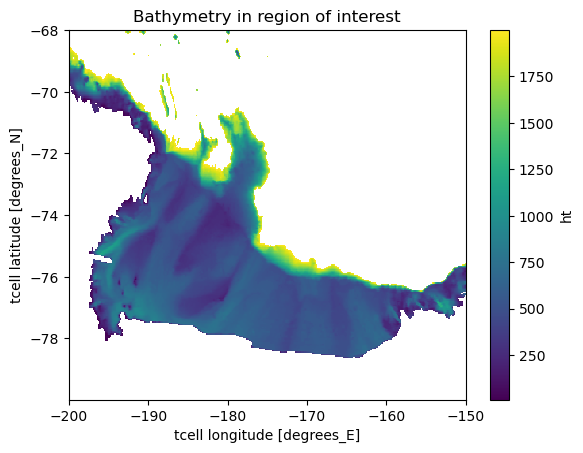

In [6]:
# Define the region of interest
lon_slice = slice(-200, -150)
lat_slice = slice(-80, -68)
mask_depth = 2000

# select correct extent of ht, hu for use later:
ht = ht.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)

# create masks:
mask_t = ht.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice) < mask_depth
mask_t = mask_t.where(mask_t != 0)

# mask bathymetry:
ht_masked = ht * mask_t

# Plot the bathymetry in the mask region:
ht_masked.plot()
plt.title('Bathymetry in region of interest')
plt.show()

### 2. Import variables for averaging, set up thickness and area for weighting, and isobath bins.

In [7]:
# Import properties to average along isobaths.

# Define the start and end times #
start_time, end_time = '2170-01-01', '2179-12-16'
# For searching with the intake catalog, we can use wildcard searches: so start_date = '217[0,9].*' means any date starting with 2170,2171..2179
# See https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#data-discovery for more info

# Define the variables we want to load
variables =['salt','temp','pot_rho_0','u','v', 'dzt']

esm_ds.search(variable=variables,frequency='1mon', start_date='217[0,9].*')

,unique
filename,1
path,8
file_id,1
frequency,1
start_date,8
end_date,8
variable,46
variable_long_name,42
variable_standard_name,11
variable_cell_methods,2


All our variables are in the one dataset - so we can load them all at once - this is more efficient than doing things separately

In [8]:
# Load the dataset
var_dataset = esm_ds.search(
    variable=variables,frequency='1mon', start_date='217[0,9].*'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
# Select out slice
var_dataset = var_dataset.sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice).sel(yu_ocean=lat_slice)

# Separate our variables into data arrays
temp = var_dataset['temp']
salt = var_dataset['salt']
density = var_dataset['pot_rho_0']
u = var_dataset['u']
v = var_dataset['v']
dzt = var_dataset['dzt']

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


#### For ease of computation, we bilinearly interpolate the u field onto the horizontal t field using xESMF

In [93]:
%%time
import xesmf as xe

ds_out = xr.Dataset()
ds_out['u'] = var_dataset['u'].rename({'xu_ocean':'lon', 'yu_ocean':'lat'})
ds_in = xr.Dataset()
ds_in['temp'] = var_dataset['temp'].rename({'xt_ocean':'lon', 'yt_ocean':'lat'})

regridder = xe.Regridder(ds_out,ds_in, "bilinear")
u_interped = regridder(u).rename({'lon':'xt_ocean', 'lat':'yt_ocean'})


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yu_ocean', 'xu_ocean') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(


CPU times: user 35.3 s, sys: 3.71 s, total: 39 s
Wall time: 39.7 s


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/computation/apply_ufunc.py:305: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 5.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (284, 800).
  result_var = func(*data_vars)


Compute volume and area for weighted averaging using `xhistogram` package, using time-varying grid cell thickness `dzt`

In [97]:
esm_ds.search(variable='st_ocean', frequency='1mon').unique().file_id

['ocean.1mon.grid_xt_ocean:3600.grid_xu_ocean:3600.grid_yt_ocean:2700.grid_yu_ocean:2700.neutral:80.neutralrho_edges:81.nv:2.potrho:80.potrho_edges:81.st_edges_ocean:76.st_ocean:75.sw_edges_ocean:76.sw_ocean:75.xt_ocean:3600.xu_ocean:3600.yt_ocean:2700.yu_ocean:2700',
 'ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700']

In [98]:
%%time
grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = esm_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.grid_xt_ocean:3600.grid_xu_ocean:3600.grid_yt_ocean:2700.grid_yu_ocean:2700.neutral:80.neutralrho_edges:81.nv:2.potrho:80.potrho_edges:81.st_edges_ocean:76.st_ocean:75.sw_edges_ocean:76.sw_ocean:75.xt_ocean:3600.xu_ocean:3600.yt_ocean:2700.yu_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=lon_slice)
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=lat_slice)
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

# area_t is in a different dataset - so we need to load it separately.
area_t = esm_ds.search(variable='area_t').to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
        "decode_timedelta" : False,
    }
)['area_t']

area_t = area_t.sel(yt_ocean=lat_slice)

volume = area_t * dzt

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


CPU times: user 9.87 s, sys: 1.23 s, total: 11.1 s
Wall time: 12.9 s


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [99]:
### MASK YOUR REGION OF INTEREST ###

volume_masked = volume * mask_t
area_t_masked = area_t * mask_t
temp_masked = temp * mask_t
u_masked = u_interped * mask_t

### 3. Bin variables into isobath depth!

Here, we bin the variables of interest by isobath using the `xhistogram` package.

First, we define the edges of the isobath bins. It does make sense for these to be the same as `st_edges_ocean` because that is the rough vertical resolution of the ACCESS-OM2-01 model.

In [101]:

bins_isobath = st_edges_ocean.values

# Next, we sum the volume-weighted variable of interest along that isobath using xhistogram
V_sum = histogram(ht_masked, bins = bins_isobath,
                  dim = ['yt_ocean', 'xt_ocean'],
                  weights = volume_masked)
A_sum = histogram(ht_masked, bins = bins_isobath,
                  dim = ['yt_ocean', 'xt_ocean'],
                  weights = area_t_masked)

TV_sum = histogram(ht_masked, bins = bins_isobath,
                   dim = ['yt_ocean', 'xt_ocean'],
                   weights = volume_masked * temp_masked)

uV_sum = histogram(ht_masked, bins = bins_isobath,
                   dim = ['yt_ocean', 'xt_ocean'],
                   weights = u_masked * volume_masked)

# Finally, we divide the summed, volume-weighted variable of interest by volume, to get a mean along an isobath

T_mean = TV_sum / V_sum
u_mean = uV_sum / V_sum

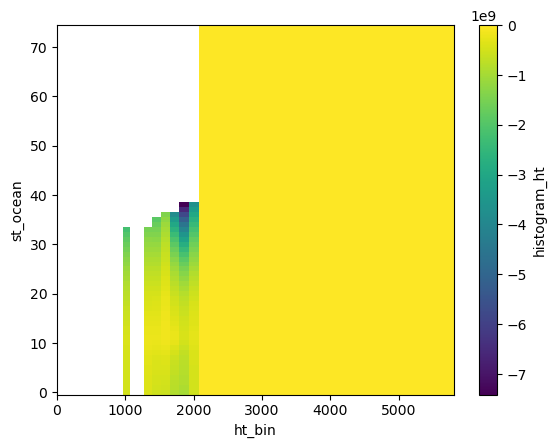

In [103]:
uV_sum.isel(time=0).plot()

The binning above creates an averaged field as a function of isobath.

Let's plot this to see what it looks like!

In [ ]:
plt.pcolor(T_mean.ht_bin, temp_masked.st_ocean, T_mean.mean('time')-273.15)
plt.gca().invert_yaxis()
plt.ylim(2000,0)
plt.xlim(0,2000)
plt.xlabel('Isobath [m]')
plt.ylabel('Depth [m]')
plt.colorbar(label = 'Temperature [$^\circ$C]')
plt.title('Temperature averaged along isobath');

## Each variable is averaged along isobaths, so the bathymetry looks diagonal in the plot #

We can rescale the isobath (x-axis) to be scaled by the cumulative surface area covered by each isobath, from shallowest to deepest. This produces a "normalised area" or pseduo-latitude $x$-axis.

In [ ]:
normalised_area_cumsum = (A_sum.cumsum('ht_bin') / np.nansum(A_sum)).values

lat_max, lat_min = abs(mask_t.yt_ocean.max().values), abs(mask_t.yt_ocean.min().values)

## Here, we plot the averaged quantities as a function of normalised area (between 0 and 1)
## and pseudo-latitude
def normalised_to_pseudo_lat(normalised_area):
    return -1 * (lat_min - (lat_min - lat_max) * normalised_area)

def pseudo_lat_to_normalised(pseudo_lat):
    return (lat_min + pseudo_lat) / (lat_min - lat_max)

pseudo_lat = normalised_to_pseudo_lat(normalised_area_cumsum)

In [ ]:
%%time
## Finally, plot the isobath-averaged properties. This should take about 3 minutes on a Large ARE Instance


fig, axs = plt.subplots(2, 1, figsize=(12, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.35, wspace=0.2)
axs = axs.ravel()

fontsize = 13

im1 = axs[0].contourf(normalised_area_cumsum, st_ocean, T_mean.mean('time') - 273.15, levels=500,
                      vmin=-2, vmax=2, cmap=plt.cm.bwr)
im4 = axs[1].contourf(normalised_area_cumsum, st_ocean, u_mean.mean('time'), levels=500,
                      vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

density_contours = np.linspace(1027.7, 1028, 5)

for i, ax in enumerate(axs):
    ax.invert_yaxis()
    ax.set_xlabel('Normalised distance from Antarctica')
    ax.set_ylim(mask_depth, 0)

    # Secondary x-axis: pseudo_lat
    twin_ax = ax.twiny()
    twin_ax.set_xlim(ax.get_xlim())  # Align the limits to match the shared x-axis
    twin_ax.set_xticks(pseudo_lat_to_normalised(np.arange(-80, -68, 2)))  # Match tick positions
    twin_ax.set_xticklabels(np.arange(-80, -68, 2))  # Replace tick labels with pseudo_lat values
    twin_ax.set_xlabel('Pseudo-Latitude (°)')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.2, orientation='horizontal')
cb4 = plt.colorbar(im4, ax=axs[1], fraction=0.03, pad=0.2, orientation='horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

cb1.set_ticks(np.linspace(np.min(T_mean.mean('time') - 273.15), np.max(T_mean.mean('time') - 273.15), 5))
cb4.set_ticks(np.linspace(np.min(u_mean.mean('time')), np.max(u_mean.mean('time')), 4))

plt.suptitle('Isobath-averaged properties', y=0.95);
